#**A Bayesian Network to model the influence of some behavioural risk factors on Cardiovascular diseases**.

##By Zarmina Ursino, zarmina.ursino@studio.unibo.it

Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

---



In [28]:
pip install pgmpy


#Modules

In [29]:
from pandas import read_csv, DataFrame
import pandas
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.independencies.Independencies import IndependenceAssertion
from pgmpy.inference import VariableElimination


#Reading csv file



There are 3 types of input features:

- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.


1.   Age | Objective Feature | age | int (days)|
2.   Height | Objective Feature | height | int (cm) 
3.   Weight | Objective Feature | weight | float (kg) |
4.   Gender | Objective Feature | Gender | categorical code |
5.   Systolic blood pressure | Examination Feature | Ap_hi | int |
6.   Diastolic blood pressure | Examination Feature | Ap_lo | int |
7.   Cholesterol | Examination Feature | Cholesterol | 1: normal, 2: above normal, 3: well above normal |
8.   Glucose | Examination Feature | Gluc | 1: normal, 2: above normal, 3: well above normal |
9.   Smoking | Subjective Feature | Smoke | binary |
10.  Alcohol intake | Subjective Feature | Alco | binary |
11.  Physical activity | Subjective Feature | Active | binary |
12.  Presence or absence of Cardiovascular disease | Target Variable | Cardio | binary |








In [30]:
df0=read_csv("cardio_train.csv", sep=';')
print("There are {} records and {} columns in the Dataframe\n".format(df0.shape[0], df0.shape[1]))
df0.head()


There are 70000 records and 13 columns in the Dataframe



,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#Data cleaning
I decide to remove the 'id' feature because it doesn't contribute much to our target variable. Moreover, I capitalize the first letter of columns' name for the sake of notational conventions.

In [31]:
df=df0.drop('id', axis=1)
df.columns=df.columns.str.capitalize()
df.head()

,Age,Gender,Height,Weight,Ap_hi,Ap_lo,Cholesterol,Gluc,Smoke,Alco,Active,Cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


##Converting age from days to years

In [32]:
#From days to years
df['Age']=df['Age'].apply(lambda x: int(x/365))
df=df.rename(columns={'Age':'Age_(y)'})


##Converting height from cm to m

In [33]:
#From cm to m
df['Height']=df['Height'].apply(lambda x:x/100)
df=df.rename(columns={'Height':'Height_(m)'})


##Categorising ages column 

In [34]:
bins_age= [-1,0,2,4,13,20, 40,59, 110]
labels_age = ['unknown','Infant','Toddler','Kid','Teen','Young Adult','Middle-aged Adult', 'Old Adult']
df['Age_(y)'] = pandas.cut(df['Age_(y)'], bins=bins_age, labels=labels_age, right=False)

##Calculating and categorising the BMI
The Body Mass Index (BMI) is a widely used parameter for an overall assessment of body weight. It uses a simple mathematical formula to relate height to weight. It is obtained by dividing the person's weight in kg by the square of their height in metres. The result of this formula classifies the subject in a weight area that can be: normal - underweight - overweight - obesity. 

In [35]:

df['BMI']=df['Weight']/np.power((df['Height_(m)']),2) 
bins_BMI= [-1,0,18.5,24.9,29.9,40]
labels_BMI = ['unknown','underweight','normal weight','overweight','obese']
df['BMI'] = pandas.cut(df['BMI'], bins=bins_BMI, labels=labels_BMI, right=False)

##Remove weight and height

In [36]:
df=df.drop(columns=['Weight', 'Height_(m)'])


##Categorising ip_hi and ip_lo column 
Blood pressure, it’s expressed as a measurement with two numbers, with one number on top (systolic) and one on the bottom (diastolic), like a fraction. The top number refers to the amount of pressure in the arteries during the contraction of the heart muscle. This is called systolic pressure ('Ap_hi'). The bottom number refers to your blood pressure when the heart muscle is between beats. This is called diastolic pressure ('Ap_lo'). The AHA recommends specific ranges for healthy adults 

In [37]:
bins_Ap_hi= [-1,0,120,129,139,140, 180]
labels_Ap_hi = ['unknown','normal','elevated','hight_blood_pressure_stage1','hight_blood_pressure_stage2','hypertensive crisis']
df['Ap_hi'] = pandas.cut(df['Ap_hi'], bins=bins_Ap_hi, labels=labels_Ap_hi, right=False)

In [38]:
bins_Ap_lo= [-1,0,80,89,90,120]
labels_Ap_lo = ['unknown','normal','hight_blood_pressure_stage1','hight_blood_pressure_stage2','hypertensive crisis']
df['Ap_lo'] = pandas.cut(df['Ap_lo'], bins=bins_Ap_lo, labels=labels_Ap_lo, right=False)

#Bayesian Model and CPT












































































































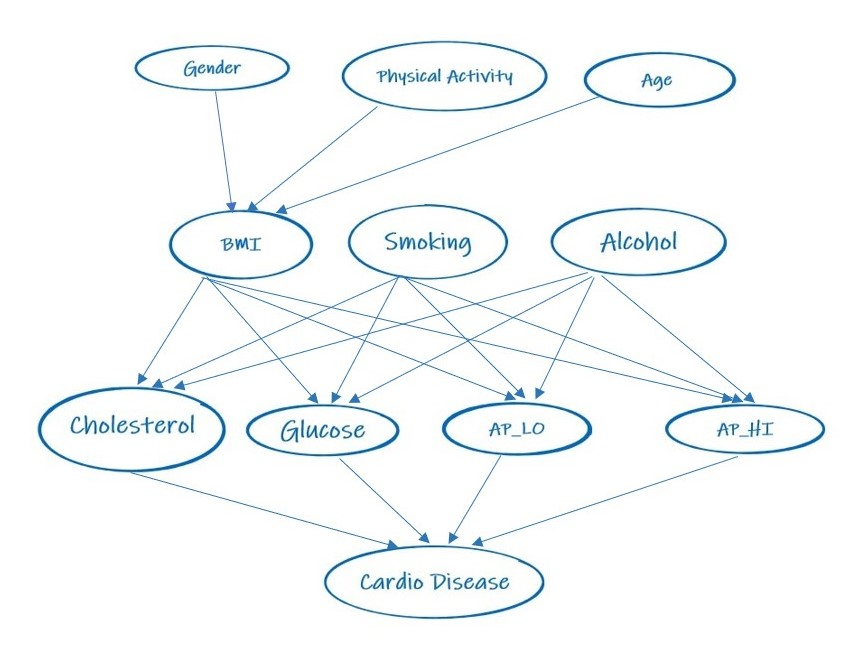

In [39]:
model=BayesianModel([('Active','BMI'),
                     ('Age_(y)','BMI'),
                     ('Gender', 'BMI'),
                     ('BMI', 'Cholesterol'),('BMI', 'Gluc'),('BMI', 'Ap_lo'),('BMI', 'Ap_hi'),
                     ('Smoke', 'Cholesterol'),('Smoke', 'Gluc'),('Smoke', 'Ap_lo'),('Smoke', 'Ap_hi'),
                     ('Alco', 'Cholesterol'),('Alco', 'Gluc'),('Alco', 'Ap_lo'),('Alco', 'Ap_hi'),
                     ('Cholesterol', 'Cardio'),('Gluc', 'Cardio'),('Ap_lo', 'Cardio'),('Ap_hi','Cardio'),
                     ])

In [40]:
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(data=df, 
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')
    

Check model: True

CPT of Active:
+-----------+----------+
| Active(0) | 0.196315 |
+-----------+----------+
| Active(1) | 0.803685 |
+-----------+----------+ 

CPT of BMI:
+--------------------+----------------------------+----------------------------+----------------------+----------------------+----------------------+----------------------+----------------------------+----------------------------+----------------------+----------------------+----------------------+----------------------+
| Active             | Active(0)                  | Active(0)                  | Active(0)            | Active(0)            | Active(0)            | Active(0)            | Active(1)                  | Active(1)                  | Active(1)            | Active(1)            | Active(1)            | Active(1)            |
+--------------------+----------------------------+----------------------------+----------------------+----------------------+----------------------+----------------------+---------

#Independencies


In [41]:
nodes=['BMI','Age_(y)','Active','Smoke','Alco','Cholesterol','Gluc','Ap_lo','Ap_hi','Cardio'] 
print(f'There can be made {len(model.get_independencies().get_assertions())}',
      'valid independence assertions with respect to the all possible given evidence.')
print('Any node in the network is independent of its non-descendents given its parents (local semantics):\n',
      f'\n{model.local_independencies(nodes)}\n')

There can be made 4942 valid independence assertions with respect to the all possible given evidence.
Any node in the network is independent of its non-descendents given its parents (local semantics):
 
(BMI ⟂ Smoke, Alco | Gender, Age_(y), Active)
(Age_(y) ⟂ Gender, Smoke, Alco, Active)
(Active ⟂ Gender, Smoke, Age_(y), Alco)
(Smoke ⟂ Gender, Age_(y), Alco, BMI, Active)
(Alco ⟂ Gender, Age_(y), Smoke, BMI, Active)
(Cholesterol ⟂ Gender, Age_(y), Gluc, Ap_lo, Ap_hi, Active | Smoke, BMI, Alco)
(Gluc ⟂ Gender, Age_(y), Ap_hi, Ap_lo, Cholesterol, Active | Smoke, BMI, Alco)
(Ap_lo ⟂ Gender, Age_(y), Gluc, Ap_hi, Cholesterol, Active | Smoke, BMI, Alco)
(Ap_hi ⟂ Gender, Age_(y), Gluc, Ap_lo, Cholesterol, Active | Smoke, BMI, Alco)
(Cardio ⟂ Gender, Age_(y), Alco, Smoke, BMI, Active | Ap_hi, Ap_lo, Gluc, Cholesterol)



#The independence assertions

In [42]:
def independent_assertions_score(node):
    return len([a for a in model.get_independencies().get_assertions() if node in a.event1])

def evidence_assertions_score(node):
    return len([a for a in model.get_independencies().get_assertions() if node in a.event3])

def calculations(assertion_dict, node, score_function):
    tmp_score = score_function(node)
    if tmp_score == assertion_dict["max"]["score"]:
        assertion_dict["max"]["nodes"].append(node)
    elif tmp_score > assertion_dict["max"]["score"]:
        assertion_dict["max"]["nodes"] = [node]
        assertion_dict["max"]["score"] = tmp_score
    if tmp_score == assertion_dict["min"]["score"]:
        assertion_dict["min"]["nodes"].append(node)
    elif tmp_score < assertion_dict["min"]["score"]:
        assertion_dict["min"]["nodes"] = [node]
        assertion_dict["min"]["score"] = tmp_score  

if len(nodes) > 1:
    independent_init = independent_assertions_score(nodes[0])
    independent_dict = {"max": {"nodes": [nodes[0]], "score": independent_init}, 
                       "min": {"nodes": [nodes[0]], "score": independent_init}}
    evidence_init = evidence_assertions_score(nodes[0]) 
    evidence_dict = {"max": {"nodes": [nodes[0]], "score": evidence_init}, 
                    "min": {"nodes": [nodes[0]], "score": evidence_init}} 
    for node in nodes[1:]:
        calculations(independent_dict, node, independent_assertions_score)
        calculations(evidence_dict, node, evidence_assertions_score)

print(f'Nodes which appear most ({independent_dict["max"]["score"]} times) in independence assertions',
      f'as independent variable are:\n{set(independent_dict["max"]["nodes"])}')
print(f'Nodes which appear least ({independent_dict["min"]["score"]} times) in independence assertions',
      f'as independent variable are:\n{set(independent_dict["min"]["nodes"])}')
print(f'Nodes which appear most ({evidence_dict["max"]["score"]} times) in independence assertions',
      f'as evidence are:\n{set(evidence_dict["max"]["nodes"])}')
print(f'Nodes which appear least ({evidence_dict["min"]["score"]} times) in independence assertions',
      f'as evidence are:\n{set(evidence_dict["min"]["nodes"])}')


Nodes which appear most (539 times) in independence assertions as independent variable are:
{'Age_(y)', 'Active'}
Nodes which appear least (56 times) in independence assertions as independent variable are:
{'BMI'}
Nodes which appear most (4697 times) in independence assertions as evidence are:
{'BMI'}
Nodes which appear least (1995 times) in independence assertions as evidence are:
{'Age_(y)', 'Active'}


#Checking assertions

In [43]:

def check_assertion(model, independent, from_variables, evidence):
    assertion = IndependenceAssertion(independent, from_variables, evidence)
    result = False
    for a in model.get_independencies().get_assertions():
        if frozenset(assertion.event1) == a.event1 and assertion.event2 <= a.event2 and frozenset(assertion.event3) == a.event3:
            result = True
            break
    print(f'{assertion}: {result}')

check_assertion(model, independent=['BMI'], from_variables=['Age_(y)'], evidence=[])
check_assertion(model, independent=['Gender'], from_variables=['Age_(y)'], evidence=[])
check_assertion(model, independent=['Gender'], from_variables=['Age_(y)'], evidence=['BMI'])

(BMI ⟂ Age_(y)): False
(Gender ⟂ Age_(y)): True
(Gender ⟂ Age_(y) | BMI): False


#Active trails and markov blanket

In [44]:
def active_trails_of(query, evidence):
    a = model.active_trail_nodes(query, observed=evidence).get(query)
    a.remove(query)
    if a:
        if evidence:
            print(f'Active trails between \'{query}\' and {a} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {a} given no evidence.')
    else:
        print(f'No Active trails for \'{query}\' given the evidence {set(evidence)}.')
        
def markov_blanket_of(node):
    print(f'Markov blanket of \'{node}\' is {set(model.get_markov_blanket(node))}')

markov_blanket_of(node='Cardio')
active_trails_of(query='Cardio', evidence=[])
active_trails_of(query='Cardio', evidence=['Age_(y)'])
active_trails_of(query='Cholesterol', evidence=[])
active_trails_of(query='Cholesterol', evidence=['Active'])
active_trails_of(query='Cholesterol', evidence=['BMI'])



Markov blanket of 'Cardio' is {'Ap_lo', 'Gluc', 'Ap_hi', 'Cholesterol'}
Active trails between 'Cardio' and {'Ap_hi', 'Cholesterol', 'Active', 'Gender', 'Age_(y)', 'Alco', 'Smoke', 'Ap_lo', 'BMI', 'Gluc'} given no evidence.
Active trails between 'Cardio' and {'Ap_hi', 'Cholesterol', 'Active', 'Gender', 'Alco', 'Smoke', 'Ap_lo', 'BMI', 'Gluc'} given the evidence {'Age_(y)'}.
Active trails between 'Cholesterol' and {'Cardio', 'Ap_hi', 'Active', 'Gender', 'Age_(y)', 'Alco', 'Smoke', 'Ap_lo', 'BMI', 'Gluc'} given no evidence.
Active trails between 'Cholesterol' and {'Cardio', 'Ap_hi', 'Gender', 'Age_(y)', 'Alco', 'Smoke', 'Ap_lo', 'BMI', 'Gluc'} given the evidence {'Active'}.
Active trails between 'Cholesterol' and {'Gluc', 'Cardio', 'Alco', 'Smoke', 'Ap_hi', 'Ap_lo'} given the evidence {'BMI'}.


#Variable Elimination Queries


In [45]:
Cardio_inference=VariableElimination(model)

##Query 1: P(Cardio|alc=1, Gluc=3, chol=3, BMI=obese)


In [46]:
q_1=Cardio_inference.query(['Cardio'],{'Alco':1,'Gluc':3,'Cholesterol':3, 'BMI':'obese'})
print('\n\nP(Cardio|alc=1, Gluc=3, chol=3, BMI=obese)')
print(q_1)

Eliminating: Smoke: 100%|██████████| 3/3 [00:00<00:00, 175.89it/s]



P(Cardio|alc=1, Gluc=3, chol=3, BMI=obese)
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.2979 |
+-----------+---------------+
| Cardio(1) |        0.7021 |
+-----------+---------------+


##Query 2: P(Cardio|alc=0, Gluc=2, chol=2, BMI=obese)



In [47]:
q_2=Cardio_inference.query(['Cardio'],{'Alco':0,'Gluc':2,'Cholesterol':2, 'BMI':'obese'})
print('\n\nP(Cardio|alc=0, Gluc=2, chol=2, BMI=obese)')
print(q_2)

Eliminating: Smoke: 100%|██████████| 3/3 [00:00<00:00, 148.53it/s]



P(Cardio|alc=0, Gluc=2, chol=2, BMI=obese)
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.3975 |
+-----------+---------------+
| Cardio(1) |        0.6025 |
+-----------+---------------+


##Query 3: P(Cardio|alc=0, Gluc=1, chol=1, BMI=overweight)



In [48]:
q_3=Cardio_inference.query(['Cardio'],{'Alco':0,'Gluc':1,'Cholesterol':1, 'BMI':'overweight'})
print('\n\nP(Cardio|alc=0, Gluc=1, chol=1, BMI=overweight)')
print(q_3)

Eliminating: Smoke: 100%|██████████| 3/3 [00:00<00:00, 158.69it/s]



P(Cardio|alc=0, Gluc=1, chol=1, BMI=overweight)
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.5310 |
+-----------+---------------+
| Cardio(1) |        0.4690 |
+-----------+---------------+


##Query 4: P(Cardio|alc=0, Gluc=1, chol=1, BMI= normal weight)





In [49]:
q_4=Cardio_inference.query(['Cardio'],{'Alco':0,'Gluc':1,'Cholesterol':1, 'BMI':'normal weight'})
print('\n\nP(Cardio|alc=0, Gluc=1, chol=1, BMI= normal weight)')
print(q_4)

Eliminating: Smoke: 100%|██████████| 3/3 [00:00<00:00, 101.46it/s]



P(Cardio|alc=0, Gluc=1, chol=1, BMI= normal weight)
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.6029 |
+-----------+---------------+
| Cardio(1) |        0.3971 |
+-----------+---------------+


##Query 5: P(Cardio|alc=1, Gluc=3, chol=3, BMI= underweight)


In [50]:
q_5=Cardio_inference.query(['Cardio'],{ 'Alco':1,'Gluc':3,'Cholesterol':3, 'BMI':'underweight'})
print('\n\nP(Cardio|alc=1, Gluc=3, chol=3, BMI= underweight)')
print(q_5)

Eliminating: Smoke: 100%|██████████| 3/3 [00:00<00:00, 58.56it/s]



P(Cardio|alc=1, Gluc=3, chol=3, BMI= underweight)
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.4339 |
+-----------+---------------+
| Cardio(1) |        0.5661 |
+-----------+---------------+


##Query 6: P(Cardio|alc=0, Gluc=1, chol=1, age=Young Adult)

In [51]:
q_6=Cardio_inference.query(['Cardio'],{ 'Alco':0,'Gluc':1,'Cholesterol':1,'Age_(y)':'Young Adult'})
print('\n\nP(Cardio|alc=0, Gluc=1, chol=1, age=Young Adult')
print(q_6)

Eliminating: BMI: 100%|██████████| 6/6 [00:00<00:00, 121.33it/s]



P(Cardio|alc=0, Gluc=1, chol=1, age=Young Adult
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.5582 |
+-----------+---------------+
| Cardio(1) |        0.4418 |
+-----------+---------------+


##Query 7: P(Cardio|alc=0, Gluc=1, chol=1, age=Old Adult)

In [52]:
q_7=Cardio_inference.query(['Cardio'],{ 'Alco':0,'Gluc':1,'Cholesterol':1,'Age_(y)':'Old Adult'})
print('\n\nP(Cardio|alc=0, Gluc=1, chol=1, age=Old Adult)')
print(q_7)

Eliminating: BMI: 100%|██████████| 6/6 [00:00<00:00, 82.11it/s]




P(Cardio|alc=0, Gluc=1, chol=1, age=Old Adult)
+-----------+---------------+
| Cardio    |   phi(Cardio) |
+===========+===============+
| Cardio(0) |        0.5388 |
+-----------+---------------+
| Cardio(1) |        0.4612 |
+-----------+---------------+
